In [1]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')
// Get the current notebook name (for backup purposes)

<IPython.core.display.Javascript object>

In [2]:
### BACKUP THE CURRENT NOTEBOOK TO S3 ###
### IF THIS CELL FAILS RUN THE ONE ABOVE IT AND TRY AGAIN ### 
import boto3 
import os 
backup_bucket_name = "backups-final"
s3_client = boto3.client(
    's3',
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY')
)
nb_full_path = os.path.join(os.getcwd(), nb_name)
s3_client.upload_file(nb_full_path, backup_bucket_name, nb_name)

In [3]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import functions

In [4]:
sql = SQLContext(sc)

In [15]:
data_dir = 's3://geo-final'
out_dir = 's3://cleaned-geo-final'
geo_file = data_dir + '/sample_geo.txt'
clean_latlon_file = out_dir + '/clean_sample_geo.txt'

In [16]:
from pyspark.sql.types import *

geo_df_schema = StructType(
  [StructField('lat', DoubleType()),
   StructField('long', DoubleType()),
   StructField('locationID', IntegerType())]
)


In [17]:
geo_df = sql.read.csv(geo_file, sep=r'\t',header=True)

In [18]:
geo_df.show()

+-----------+------------+----------+
|   Latitude|   Longitude|LocationID|
+-----------+------------+----------+
|37.77253945|-77.49954987|         1|
|42.09013298|-87.68915558|         2|
|39.56341754|-75.58753204|         3|
|39.45302347|-87.69374084|         4|
| 38.9537989|-77.01656342|         5|
|39.90031211|-75.74486542|         6|
|36.24009843|-115.1586914|         7|
|26.11330818|-80.09202576|         8|
|34.27036086|-118.3162918|         9|
|38.81664153|-97.62573242|        10|
|33.67614531|-118.1892776|        11|
|28.74612042|-81.44248199|        12|
|38.35152702|-81.69611359|        13|
|39.57271402|-86.35784912|        14|
|30.19543489|-81.45937347|        15|
|40.49826888|-74.16846466|        16|
|34.05601838|-117.9957428|        17|
|38.14426403|-122.5368347|        18|
|38.92940099|-94.39599609|        19|
|39.51639552|-77.81656647|        20|
+-----------+------------+----------+
only showing top 20 rows



##### For the rest of this project we just want lat and lon

In [19]:
latlon_df = geo_df.select('Latitude', 'Longitude')
latlon_df.show()

+-----------+------------+
|   Latitude|   Longitude|
+-----------+------------+
|37.77253945|-77.49954987|
|42.09013298|-87.68915558|
|39.56341754|-75.58753204|
|39.45302347|-87.69374084|
| 38.9537989|-77.01656342|
|39.90031211|-75.74486542|
|36.24009843|-115.1586914|
|26.11330818|-80.09202576|
|34.27036086|-118.3162918|
|38.81664153|-97.62573242|
|33.67614531|-118.1892776|
|28.74612042|-81.44248199|
|38.35152702|-81.69611359|
|39.57271402|-86.35784912|
|30.19543489|-81.45937347|
|40.49826888|-74.16846466|
|34.05601838|-117.9957428|
|38.14426403|-122.5368347|
|38.92940099|-94.39599609|
|39.51639552|-77.81656647|
+-----------+------------+
only showing top 20 rows



In [20]:
latlon_df.write.csv(clean_latlon_file)

In [21]:
"""
    The dataframe is converted to pandas, then a geopandas data frame to make plotting simple
"""
from shapely.geometry import Point
import geopandas as gpd
df = geo_df.toPandas()
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude,df.Latitude))

<AxesSubplot:>

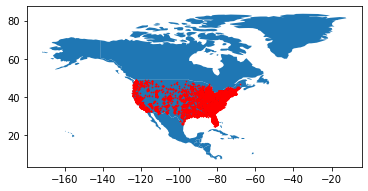

In [22]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world.continent == 'North America'].plot()
gdf.plot(ax=ax,color='red',markersize=0.5)